# Project 3: Clustering

## Business Understanding (10 points total).
• [10 points] Describe the purpose of the data set you selected (i.e., why was this data
collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific
dataset and the stakeholders needs?

## Data Understanding (20 points total)
• [10 points] Describe the meaning and type of data (scale, values, etc.) for each
attribute in the data file. Verify data quality: Are there missing values? Duplicate data?
Outliers? Are those mistakes? How do you deal with these problems?

• [10 points] Visualize the any important attributes appropriately. Important: Provide an
interpretation for any charts or graphs.

In [2]:
import pandas as pd
import numpy as np
import os
# import matplotlib.pyplot as plt
import warnings
import sklearn
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances

# import seaborn as sns
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)

In [3]:
# path = "/home/kyle/Documents/thomaskh522@gmail.com/SMU/DataMining/Classificaiton2/"
path = 'C:/Users/Casiano/Dropbox/SMU_DataScience/MSDS_7331_Data_Mining/Project3/'
df =  pd.read_csv(path + "SCADAcombined2017_T014_PROJECT3.csv")

del df['TimeStamp']
df.dropna(inplace=True)
# df = df.reset_index()

df['WindDir_D1_WVT'] = 360 - df['WindDir_D1_WVT']

print("Dimensions of data frame: ", df.shape)
print(df.info())
df.head()

Dimensions of data frame:  (52451, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52451 entries, 0 to 52461
Data columns (total 2 columns):
wtc_ScYawPos_mean    52451 non-null float64
WindDir_D1_WVT       52451 non-null float64
dtypes: float64(2)
memory usage: 1.2 MB
None


wtc_ScYawPos_mean  WindDir_D1_WVT
0           350.3289          318.22
1           356.3080          321.73
2           359.3556          319.33
3           360.1000          321.14
4           358.4161          317.56

## Modeling and Evaluation (50 points total)
Different tasks will require different evaluation methods. Be as thorough as possible when analyzing
the data you have chosen and use visualizations of the results to explain the performance and
expected outcomes whenever possible. Guide the reader through your analysis with plenty of
discussion of the results. Each option is broken down by:

• [10 Points] Train and adjust parameters

• [10 Points] Evaluate and Compare

• [10 Points] Visualize Results

• [20 Points] Summarize the Ramifications

### Option A: Cluster Analysis
• Train: Perform cluster analysis using several clustering methods (adjust parameters).

• Eval: Use internal and/or external validation measures to describe and compare the
clusterings and the clusters— how did you determine a suitable number of clusters for
each method?

• Visualize: Use tables/visualization to discuss the found results. Explain each
visualization in detail.

• Summarize: Describe your results. What findings are the most interesting and why?

### Train: Perform Custer Analysis Using Several Clustering methods and adjust parameters (10 points)

First, I want to look at wind speed vs historical power output. It will be interesting to see how different turbines are clustered together, especially if their name plate capacity is different across clusters.

#### DBSCAN

In order to train the DBSCAN clustering algorithm, the hyperparameters of Minimum Samples and Epsilon needed to be explored. Since the scoring of the model is not available witht the sci-kit learn package, the GridSearch function cannot be used like we did with supervised learning. The method here is two nested for-loops for each hyperparameter. The range for each was determined to avoid gross mislabeling. For each loop, the number of clusters was calculated(not including noise points) along with the silhouette score.  

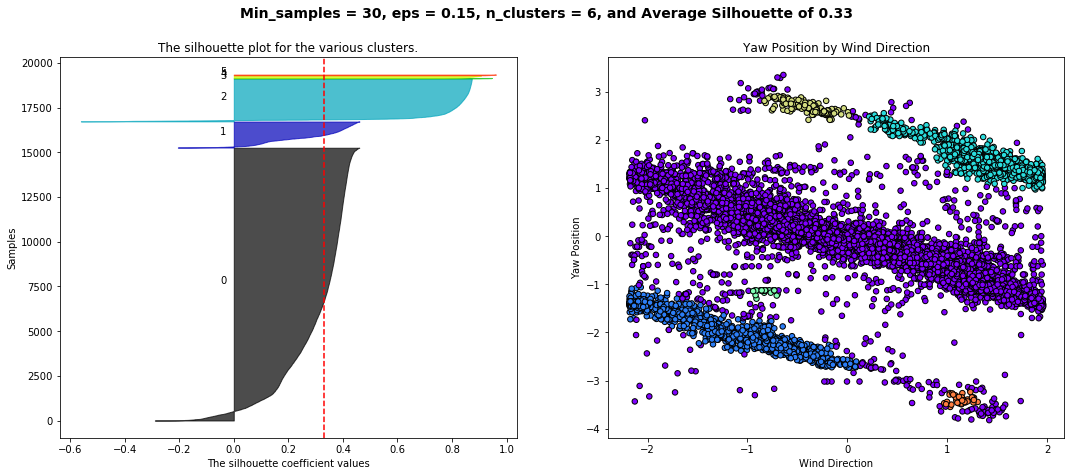

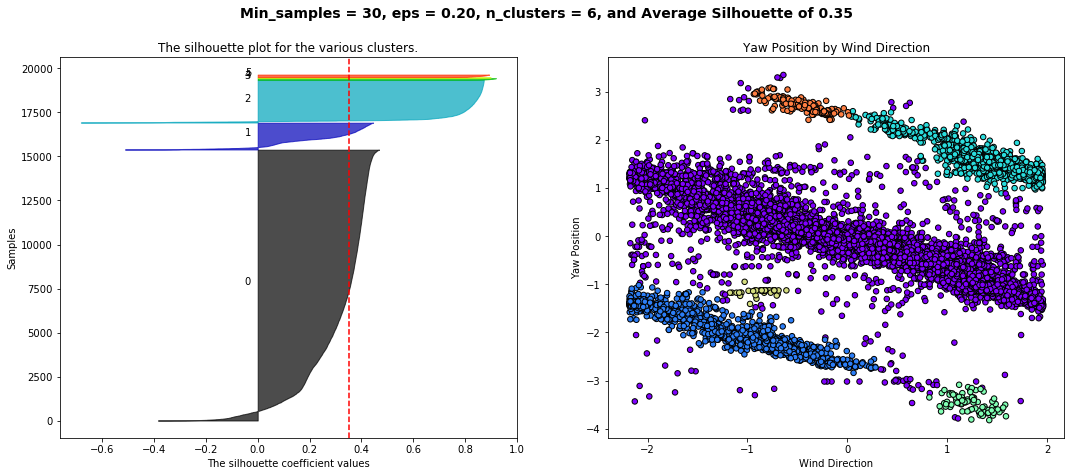

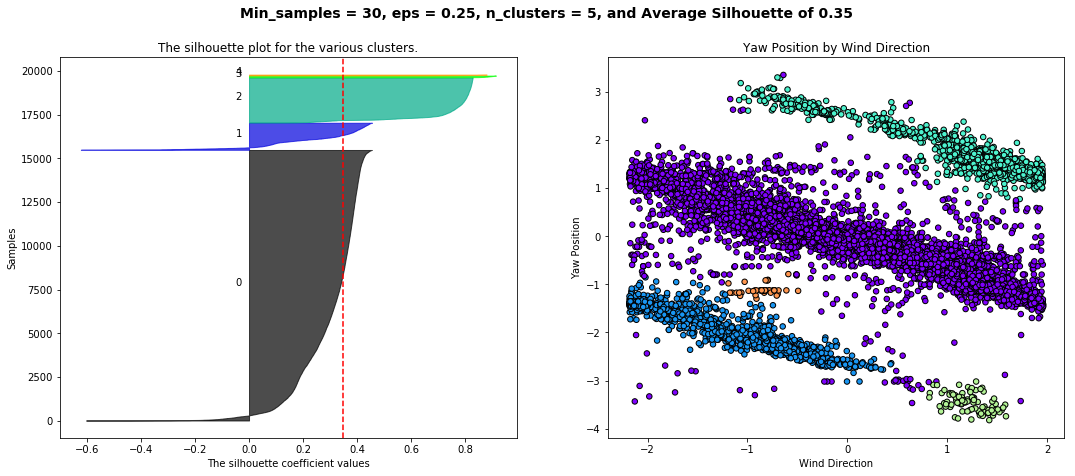

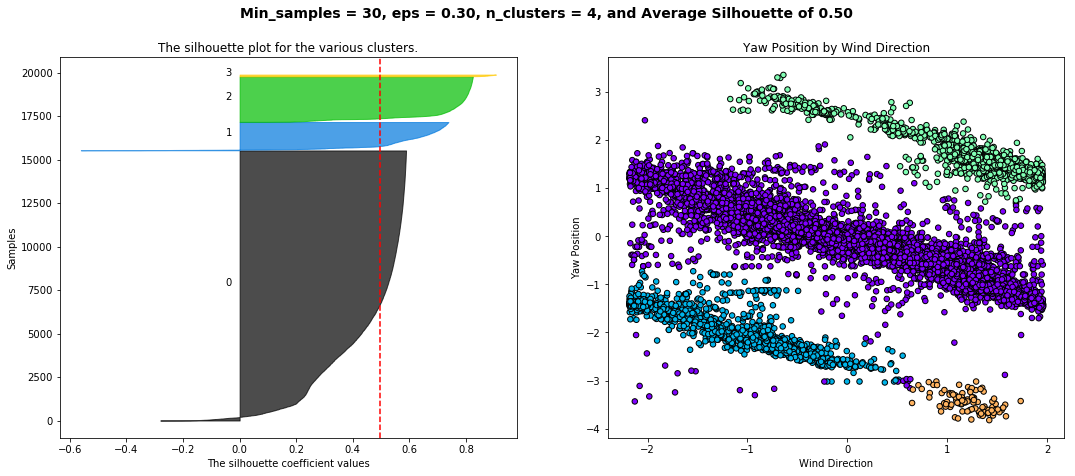

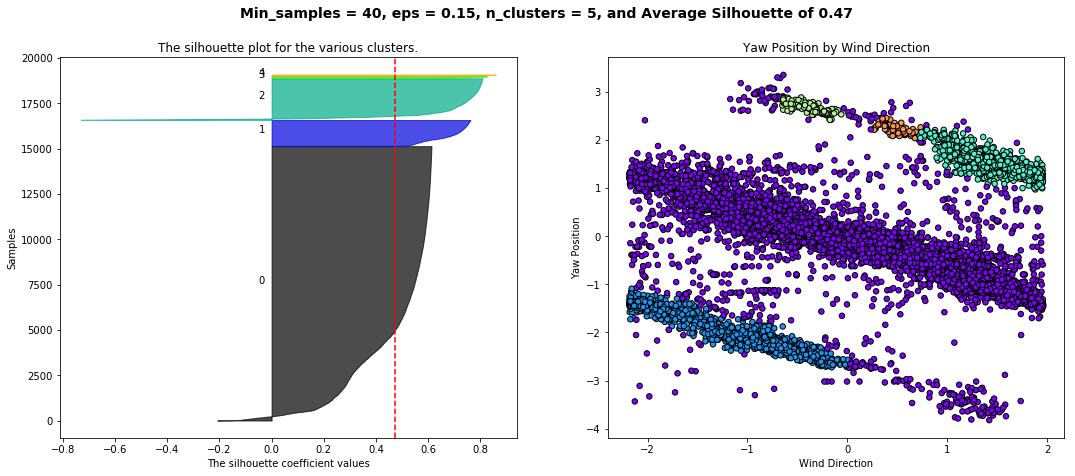

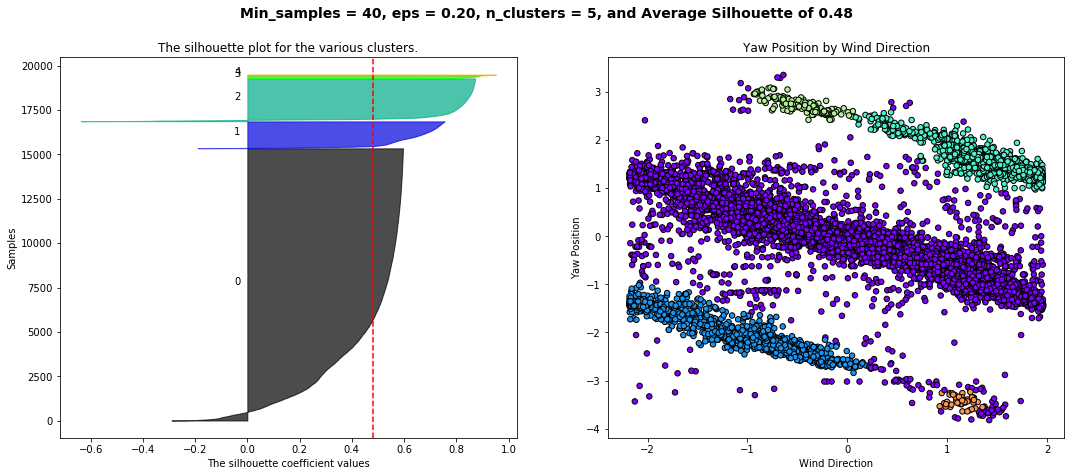

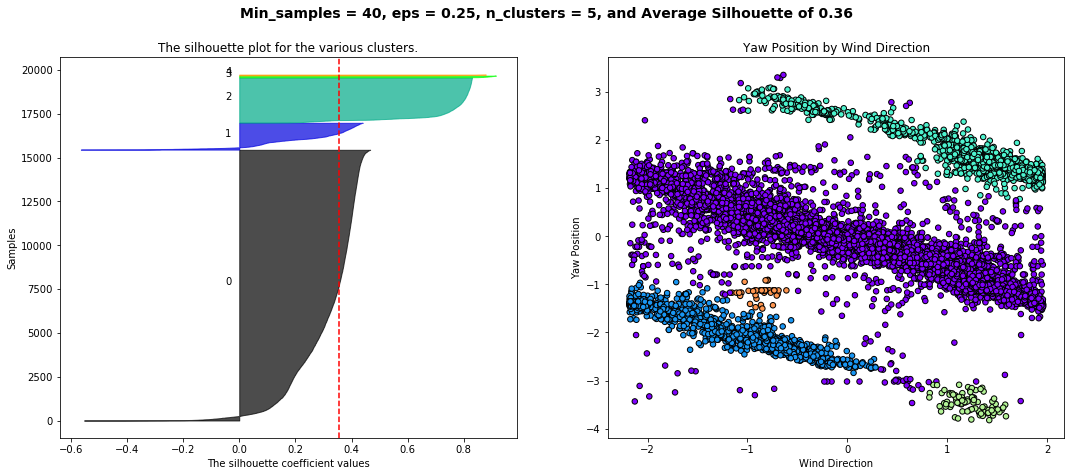

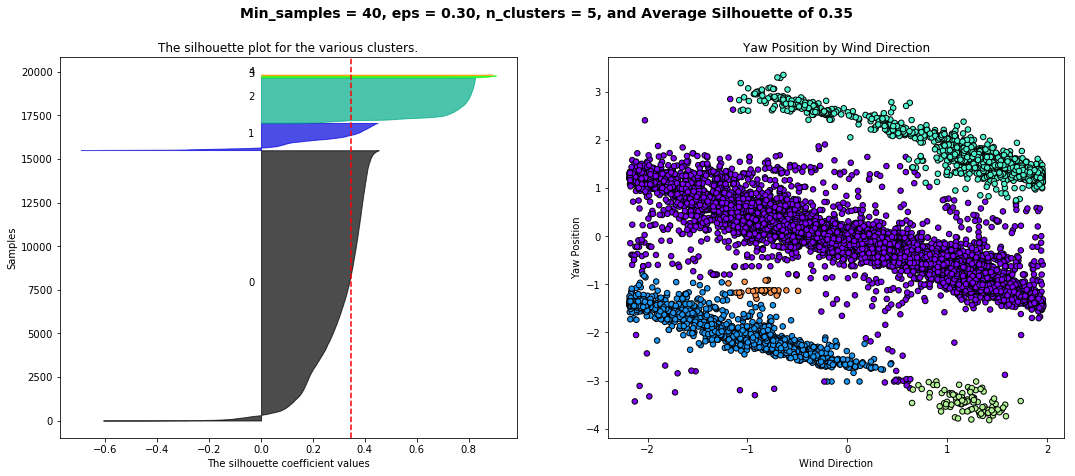

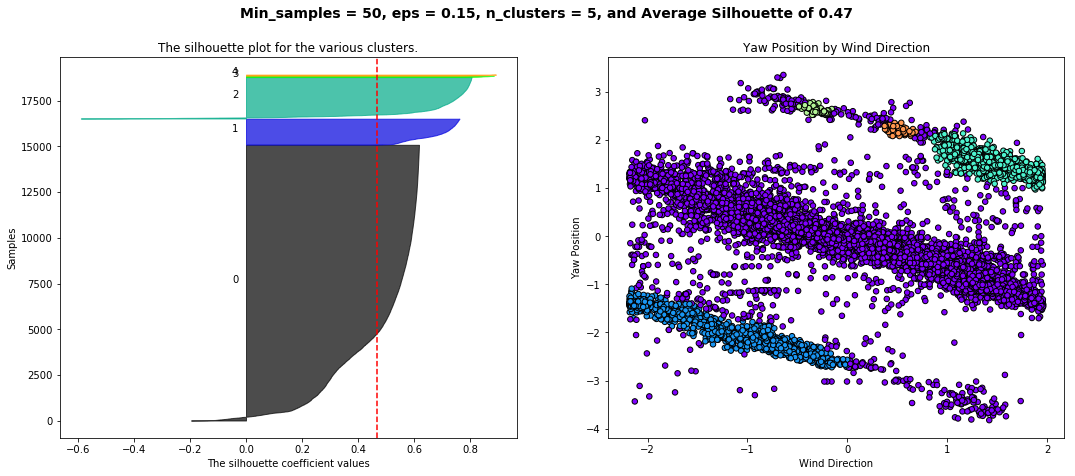

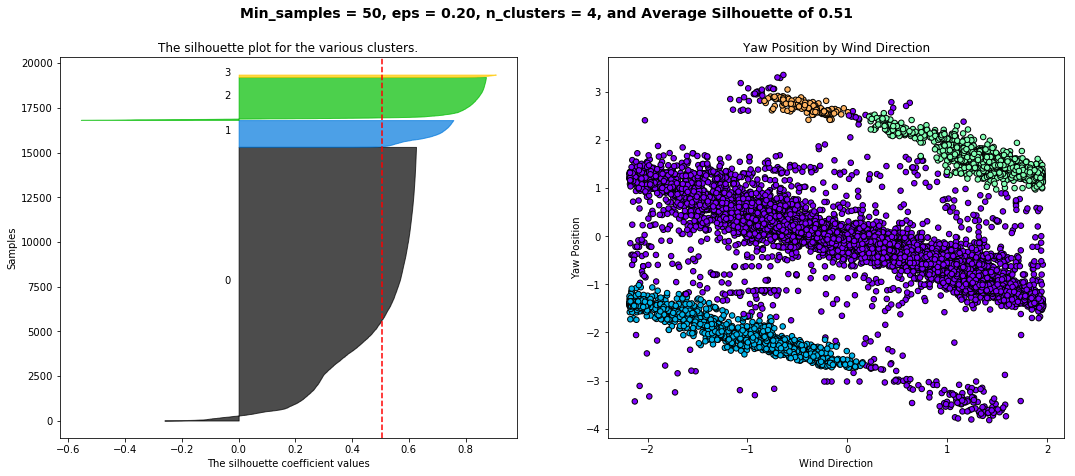

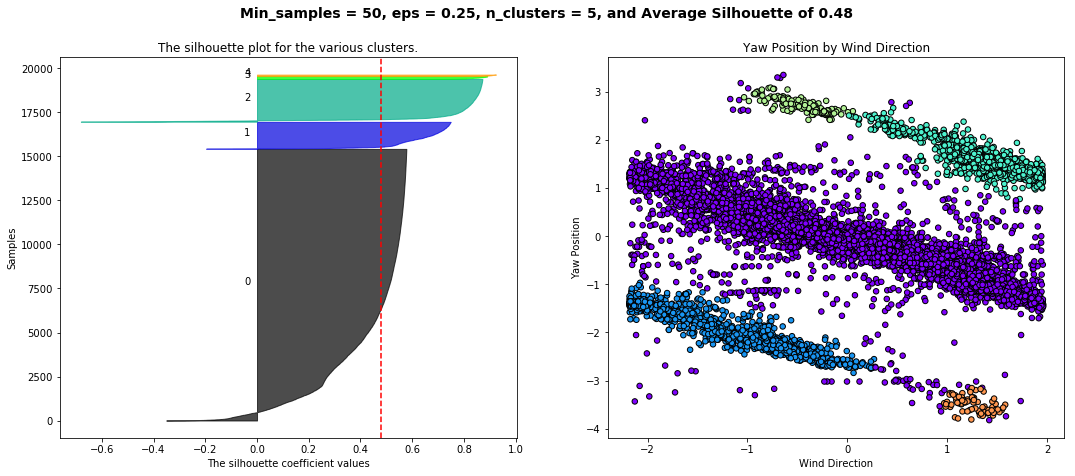

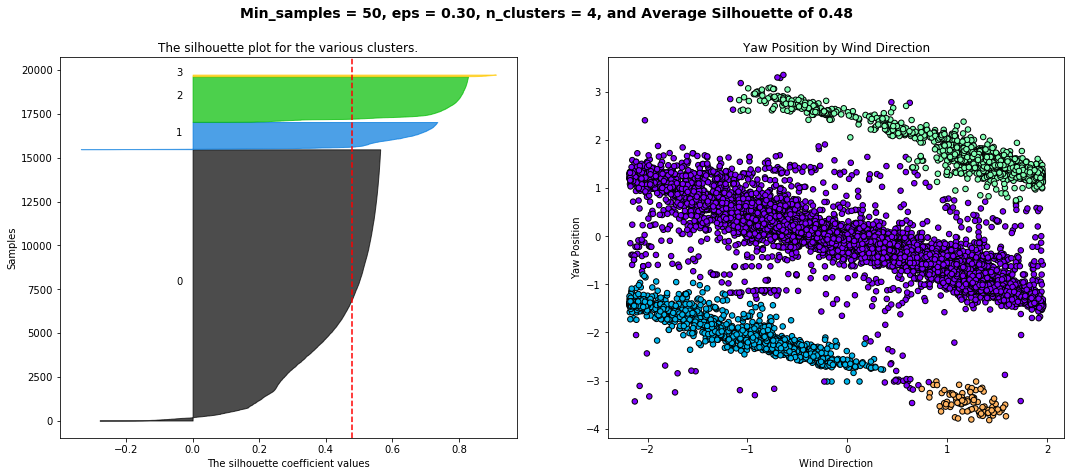

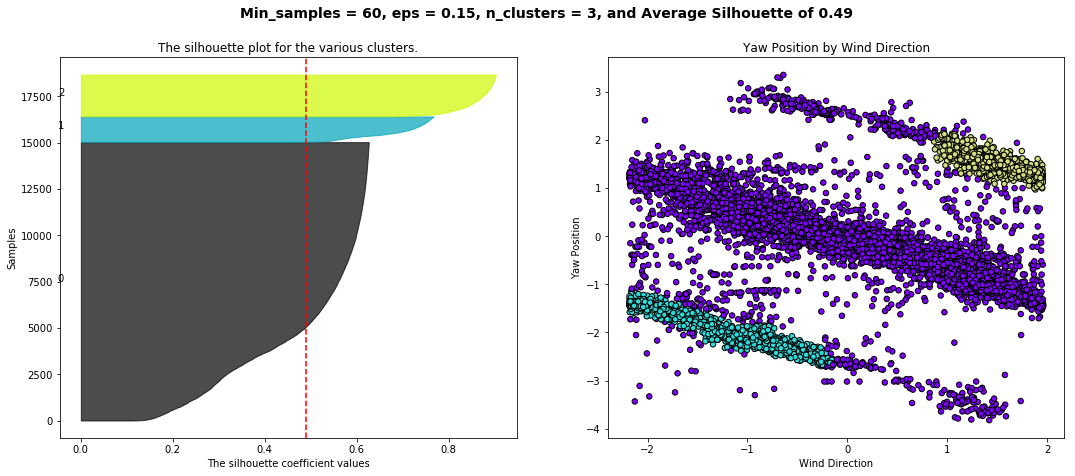

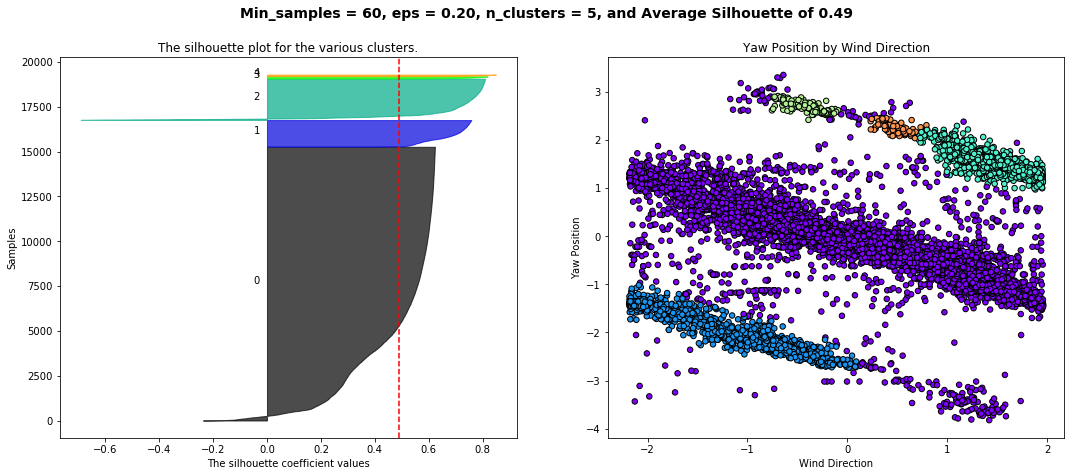

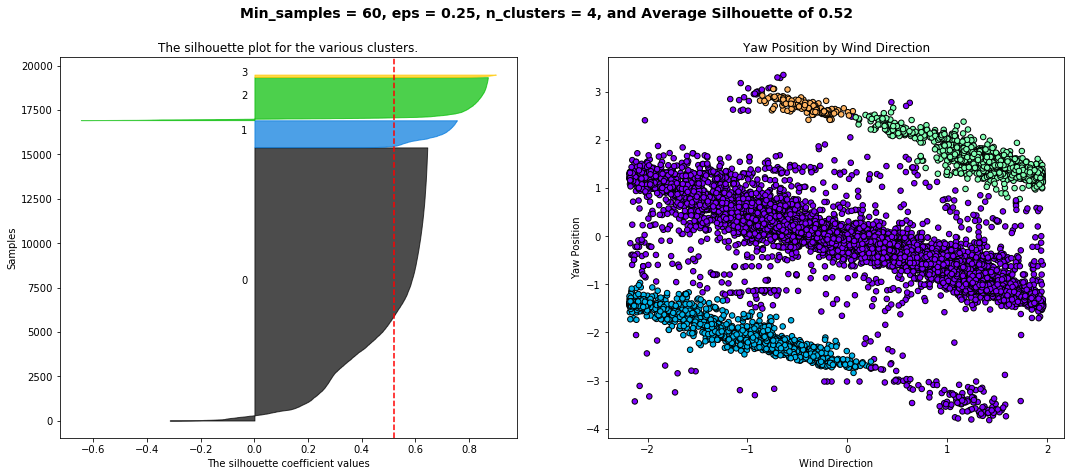

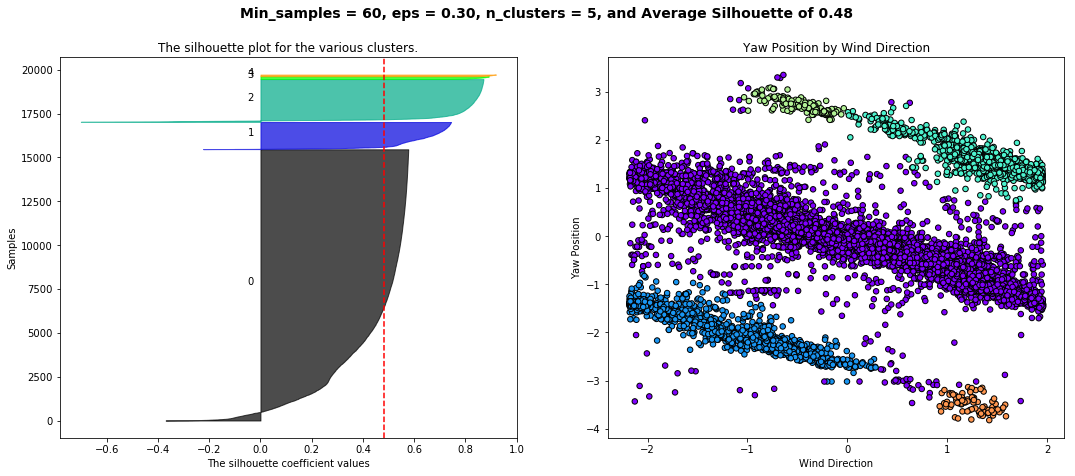

In [13]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(df.sample(20000, replace=False))

score_list = []
cluster_list = []

min_samples_range = range(30,70,10)
eps_range = np.arange(0.15,0.35,0.05)

for min_samples in min_samples_range:
    for eps in eps_range:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        model = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(X)
        cluster_labels = model.labels_

        n_clusters = len(set(model.labels_)) - (1 if -1 in model.labels_ else 0)
        cluster_list.append(n_clusters)
        
        silhouette_avg = silhouette_score(X, cluster_labels)
        score_list.append(silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Samples")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        # 2nd Plot showing the actual clusters formed
        colors = cm.rainbow(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 1], X[:, 0], marker='o', s=30, c=colors, edgecolor='k')

        ax2.set_title("Yaw Position by Wind Direction")
        ax2.set_ylabel("Yaw Position")
        ax2.set_xlabel("Wind Direction")

        plt.suptitle("Min_samples = %i, eps = %.2f, n_clusters = %i, and Average Silhouette of %.2f" %(min_samples, eps, n_clusters, silhouette_avg), fontsize=14, fontweight='bold')
        plt.show()

# References: 
# http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
# http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py


After visual inspection of the color-coded clusters, I believe the best tuned parameters are: Min Samples 50 & Epsilon 0.3. This model is shown below. The model captures the top two clusters very well. The red cluster could be considered noise and the lower cluster could be considered as two separate clusters but overall the model is good. It is clear to see how the two parameters determine the number of clusters and also now many outliers are identified. A model of 40 minimum samples and 0.25 epsilon gives a very good model but the same model with 0.3 epsilon does not. 


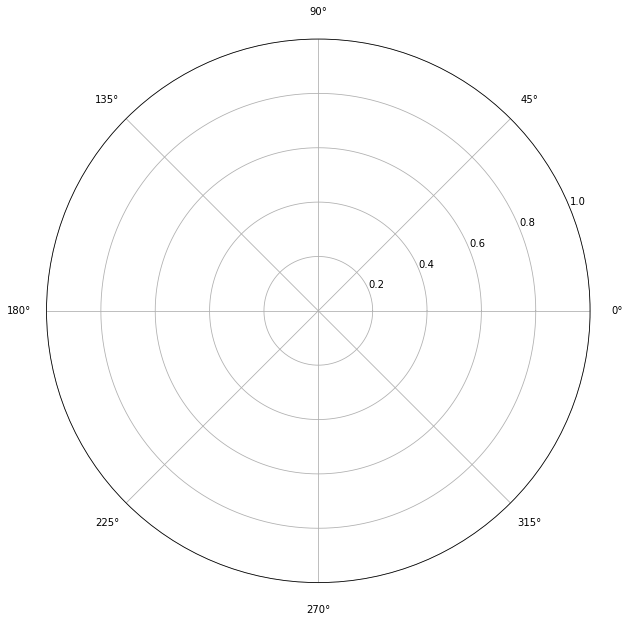

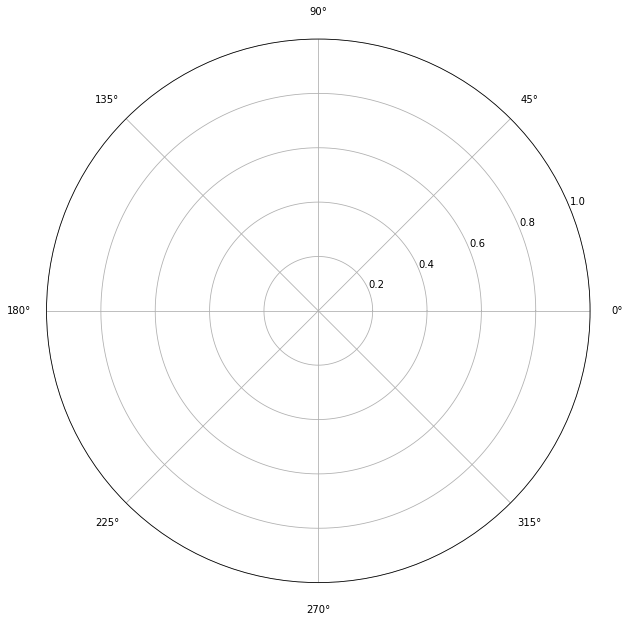

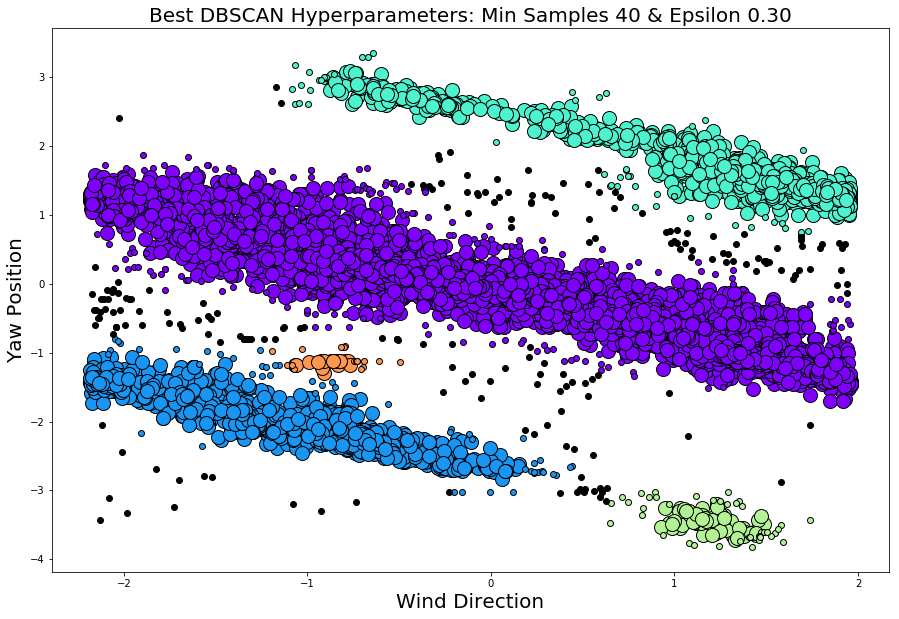

In [43]:
eps = 0.3
min_samples = 40

model = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(X)

core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
core_samples_mask[model.core_sample_indices_] = True
labels = model.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.rainbow(each)
          for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(15,10))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)



plt.title("Best DBSCAN Hyperparameters: Min Samples %i & Epsilon %.2f" %(min_samples, eps), fontsize=20)
plt.ylabel("Yaw Position", fontsize=20)
plt.xlabel("Wind Direction", fontsize=20)
plt.show()

I do not believe the silhouette metric is the best way to evaluate clustering on this dataset. Skewed results are due to the non-convex nature of the clusters. Below is a graph of how the silhouette score changes with the number of clusters. As you can see, four clusters give the best results. 

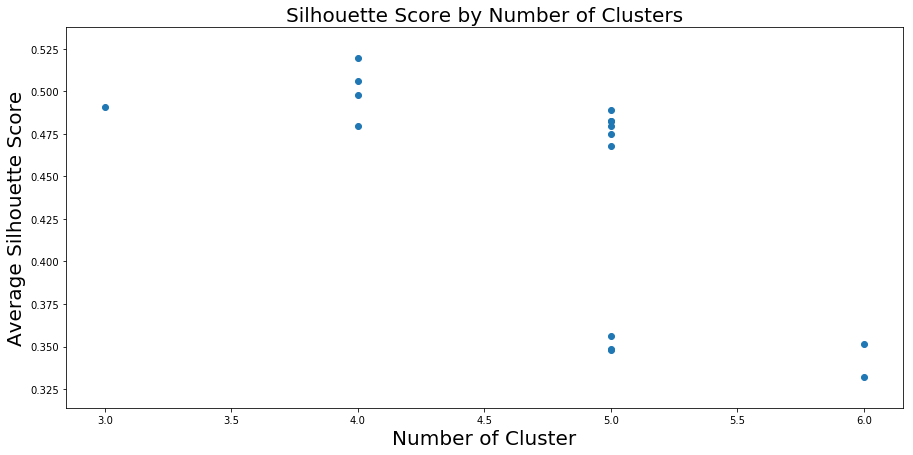

In [28]:
# Plot Silhouette score by cluster size

plt.figure(figsize=(15,7))
plt.scatter(x=cluster_list,y=score_list)
plt.ylabel("Average Silhouette Score", fontsize=20)
plt.xlabel("Number of Cluster", fontsize=20)
plt.title("Silhouette Score by Number of Clusters", fontsize=20)

plt.show()

## Deployment (10 points total)
• Be critical of your performance and tell the reader how you current model might be usable by
other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?

• How useful is your model for interested parties (i.e., the companies or organizations
that might want to use it)?

• How would your deploy your model for interested parties?

• What other data should be collected?

• How often would the model need to be updated, etc.?

The main use for clustering for this dataset would be for outlier detection. DBSCAN is a great way to identify points that do not connect to the larger population. Toward this aim, we did achieve our goal. Pattern Energy would find this outlier detection method very useful in production. These outliers can be removed to improve other calculations. The model could be deployed in batches as new data is generated. Points with a cluster label of negative one can be flagged for review or removal. No further data is needed. The model may need to be reviewed one a quarter as the environmental conditions for each season change. 

## Exceptional Work (10 points total)
• You have free reign to provide additional analyses or combine analyses.

Plotting the data in polar coordinates helps to illustrate the true nature of the data set. The error between wind direction and yaw position could be caused by a malfunction in the yaw system or a sensor calibration issue. 

In [39]:
list(model.labels_.unique())

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

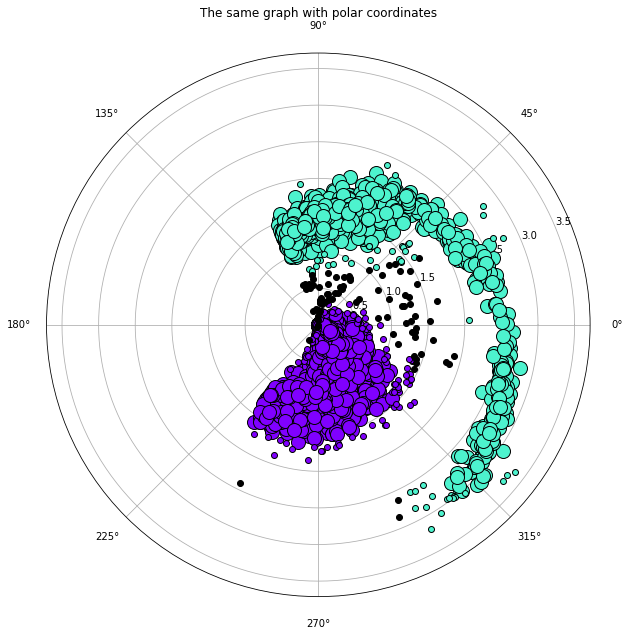

In [46]:
"""
Exceptional Work 
"""
import numpy as np
import matplotlib.pyplot as plt


r = df['wtc_ScYawPos_mean'] - df['WindDir_D1_WVT']
theta = df['WindDir_D1_WVT']
# colors = model.labels_

plt.figure(figsize=(10,10))
ax = plt.subplot(projection='polar')

# plt.figure(figsize=(15,10))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    xy = X[class_member_mask & core_samples_mask]
    ax.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    ax.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
    
ax.set_title("The same graph with polar coordinates", va='bottom')

plt.show()

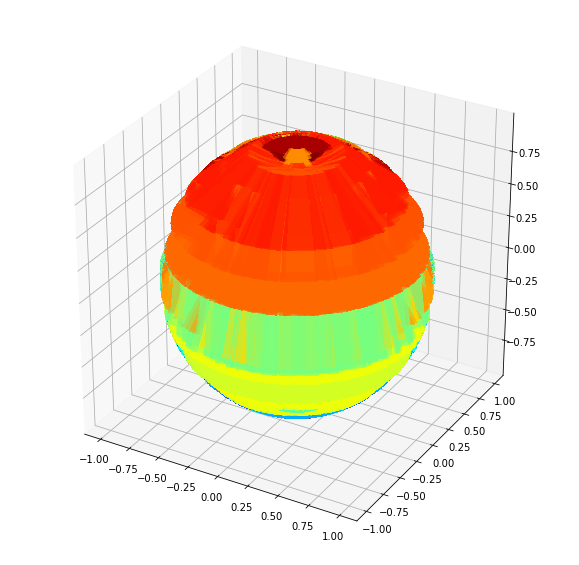

In [51]:
df2 = df.sample(500, replace=False)

import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d

# theta, phi = np.linspace(0, 2 * np.pi, 40), np.linspace(0, np.pi, 40)

phi = df2['wtc_ScYawPos_mean'] - df2['WindDir_D1_WVT']
theta = df2['WindDir_D1_WVT']

THETA, PHI = np.meshgrid(theta, phi)
R = np.cos(PHI**2)
X = R * np.sin(PHI) * np.cos(THETA)
Y = R * np.sin(PHI) * np.sin(THETA)
Z = R * np.cos(PHI)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.plot_surface(
    X, Y, Z, rstride=1, cstride=1, cmap=plt.get_cmap('jet'),
    linewidth=0, antialiased=False, alpha=0.5)

plt.show()

# Reference:
# https://matplotlib.org/examples/mplot3d/surface3d_radial_demo.html